In [2]:
import numpy as np 
import pandas as pd
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

#plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
plt.style.use('dark_background')
#mpl.rcParams['xtick.labelsize'] = 8

plt.rcParams['axes.facecolor'] = '333333'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams["savefig.facecolor"] = '333333'

%matplotlib inline

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

# Read and build spectral dataset

In [2]:
spe_dir = glob.glob('data/SO264-15-2/Run 1 at  10kV/*.spe')

In [3]:
spe_all = []
depth_all = []
cps_all = []
file_name = []

for spe in spe_dir:
    start_depth = int(spe.split()[3].split('_')[-1])
    file_name.append(spe.split('/')[-1])
    with open(spe, 'r') as f:
        content = []
        lines = f.readlines()
        for line in lines[49:]:
            content = np.hstack((content, line.split()))

        spe_all.append(content.astype(int))
        # the depth read from the xrf depth is in mm, but the composite depth is in cm
        # also I check the depth is always starts from 0.0 and in 10.0 mm resulotion
        # so I use this trick to make it to cm  e.g. '1000.0\n'
        depth_all.append(int(lines[13][:-4]) + start_depth)
        cps_all.append(int(lines[28]))

In [4]:
# just to check if all depth can be store in integer
np.where((np.array(depth_all).round() == depth_all) == False)
# the answer is positive so I use a trick to store them in integer to save space

(array([], dtype=int64),)

In [5]:
data_df = pd.DataFrame(spe_all)
data_df['composite_depth_cm'] = depth_all
data_df['cps'] = cps_all
data_df['file_name'] = file_name
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,composite_depth_cm,cps,file_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,888,169212,SO264-15-2_0848 400.0mm 10s 10kV 150uA No-F...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1437,56052,SO264-15-2_1348 890.0mm 10s 10kV 150uA No-F...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,27,106123,SO264-15-2_0000 270.0mm 10s 10kV 150uA No-F...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,982,147405,SO264-15-2_0948 340.0mm 10s 10kV 150uA No-F...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1106,216119,SO264-15-2_1048 580.0mm 10s 10kV 150uA No-F...


In [6]:
data_df.shape

(1442, 2051)

## Check duplicates

In [7]:
data_df.loc[data_df.composite_depth_cm.duplicated(keep = False), ['file_name', 'composite_depth_cm']].to_csv('results/duplicates.csv')

In [8]:
data_df.loc[data_df.composite_depth_cm.duplicated(), ['file_name', 'composite_depth_cm']]

,file_name,composite_depth_cm
193,SO264-15-2_048 20.0mm 10s 10kV 150uA No-Fi...,50
363,SO264-15-2_048 330.0mm 10s 10kV 150uA No-Fi...,81
372,SO264-15-2_0048 100.0mm 10s 10kV 150uA No-F...,58
373,SO264-15-2_0048 60.0mm 10s 10kV 150uA No-F...,54
396,SO264-15-2_048 220.0mm 10s 10kV 150uA No-Fi...,70
...,...,...
1401,SO264-15-2_0048 200.0mm 10s 10kV 150uA No-F...,68
1409,SO264-15-2_048 210.0mm 10s 10kV 150uA No-Fi...,69
1425,SO264-15-2_0048 50.0mm 10s 10kV 150uA No-F...,53
1426,SO264-15-2_0048 130.0mm 10s 10kV 150uA No-F...,61


In [9]:
data_df.loc[data_df.composite_depth_cm == 50, ['file_name', 'composite_depth_cm']]

,file_name,composite_depth_cm
118,SO264-15-2_0000 500.0mm 10s 10kV 150uA No-F...,50
193,SO264-15-2_048 20.0mm 10s 10kV 150uA No-Fi...,50
692,SO264-15-2_0048 20.0mm 10s 10kV 150uA No-F...,50


It does have duplicates...I reckon it's caused by a mess duplicate scanning. I only preserve the first one (0048) because its naming is matched to others.

In [10]:
clean_df = data_df[~data_df.composite_depth_cm.duplicated()]
clean_df.shape

(1340, 2051)

## Export data

In [11]:
clean_df.to_csv('data/spe_SO264-15-2.csv')

# Merge with the bulk measurement by depth

In [13]:
#clean_df = pd.read_csv('data/spe_SO264-15-2.csv', index_col=0)
print(clean_df.shape)
print(clean_df.head())
bulk_df = pd.read_excel('data/Bulk chem/SO264-15-2_bulk.xlsx', sheet_name = 'Sheet2')
bulk_df.columns = ['mid_depth_cm', 'toc_percent', 'tc_percent', 'caco3_percent']
print(bulk_df.shape)
print(bulk_df.head())

(1340, 2051)
   0  1  2  3  4  5  6  7  8  9  ...  2041  2042  2043  2044  2045  2046  \
0  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

   2047  composite_depth_cm     cps  \
0     0                 888  169212   
1     0                1437   56052   
2     0                  27  106123   
3     0                 982  147405   
4     0                1106  216119   

                                           file_name  
0  SO264-15-2_0848  400.0mm  10s  10kV 150uA No-F...  
1  SO264-15-2_1348  890.0mm  10s  10kV 150uA No-F...  
2  SO264-15-2_0000  270.0mm  10s  10kV 150uA No-F...  
3  SO264-15-2_0948  340.0mm  10s  10kV 150uA No-F...  
4  SO264-15-2_1048  

In [14]:
# just check
bulk_df[bulk_df.mid_depth_cm.duplicated()]

,mid_depth_cm,toc_percent,tc_percent,caco3_percent


In [15]:
mask_c = (clean_df.columns != 'file_name') & (clean_df.columns != 'composite_depth_cm')
merge_df = pd.DataFrame()

for row in bulk_df.iterrows():
    mid = row[1][0]
    mask_i = (clean_df.composite_depth_cm >= int(mid)) & (clean_df.composite_depth_cm <= int(mid)+1)
    merge_df = pd.concat(
        [merge_df, clean_df.loc[mask_i, mask_c].apply(np.mean, axis = 0).append(row[1])],
        axis = 1
    )
    
merge_df = merge_df.T.reset_index(drop = True)

In [16]:
merge_df.shape

(40, 2053)

In [17]:
merge_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,mid_depth_cm,toc_percent,tc_percent,caco3_percent
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,153268.5,10.5,0.181999,8.000254,65.149516
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,122791.5,20.5,0.298746,6.007120,47.567882
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,133795.0,46.5,0.288175,6.747430,53.824967
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,152620.5,68.5,0.299631,6.199101,49.160281
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,160492.0,88.5,0.240458,7.642422,61.680569


In [22]:
merge_df.isna().any(axis=1)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21     True
22     True
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
dtype: bool

In [23]:
bulk_df.isna().any(axis=1)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
dtype: bool

In [24]:
merge_df.iloc[21:23, :]

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,mid_depth_cm,toc_percent,tc_percent,caco3_percent
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,780.5,0.123676,8.799115,72.292438
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,800.5,0.098591,10.975090,90.633864


In [25]:
clean_df[(clean_df.composite_depth_cm >= 750) & (clean_df.composite_depth_cm <= 840)]

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,composite_depth_cm,cps,file_name


It means avvatech doesn't have XRF data in these two depths...

In [26]:
merge_df = merge_df.dropna()
merge_df.shape

(38, 2053)

## Export data

In [27]:
merge_df.to_csv('data/spe+bulk_SO264-15-2.csv')

# Run regressions
1. ridged linear regression
2. kernel SVM(PCA or NMF)

In [2]:
merge_df = pd.read_csv('data/spe+bulk_SO264-15-2.csv', index_col=0)
X = merge_df.iloc[:, : -5].values
X = X / X.sum(axis = 1, keepdims = True)

## CaCO3
First we use PCA to guess how many components there might be. And quickly try out the combination of algorithms.

In [3]:
y = merge_df.caco3_percent.values

In [4]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = make_pipeline(StandardScaler(), PCA())
pca.fit(X)

CPU times: user 2.05 s, sys: 883 ms, total: 2.93 s
Wall time: 4.91 s


Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

In [5]:
len(pca.named_steps['pca'].explained_variance_ratio_)

38

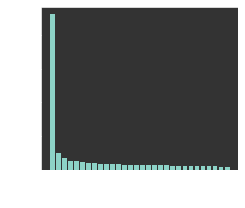

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3.54, 3))
ax.bar([_ for _ in range(1, 31)], pca.named_steps['pca'].explained_variance_ratio_[:30]*100)
ax.set_xlabel('PCs')
ax.set_ylabel('Explained variance (%)')
fig.savefig('results/screeplot_SO264-15-2.png')

Based on the elbow concept, I choose 3 to 5 as the possible component amount.

In [7]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
ridge.fit(X_train, y_train)

print('Training set score: {:.2f}'.format(ridge.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(ridge.score(X_test, y_test)))

Training set score: 1.00
Test set score: 0.91
CPU times: user 3.17 s, sys: 180 ms, total: 3.35 s
Wall time: 233 ms


In [8]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

svr = make_pipeline(StandardScaler(), PCA(whiten = True), SVR())
svr.fit(X_train, y_train)

print('Training set score: {:.2f}'.format(svr.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(svr.score(X_test, y_test)))

Training set score: -0.07
Test set score: -0.44
CPU times: user 2.08 s, sys: 57.1 ms, total: 2.14 s
Wall time: 133 ms


In [9]:
%%time
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR


svr = make_pipeline(NMF(n_components = 5, random_state = 24, max_iter=2000), SVR())
svr.fit(X_train, y_train)

print('Training set score: {:.2f}'.format(svr.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(svr.score(X_test, y_test)))

Training set score: 0.20
Test set score: 0.06
CPU times: user 10.6 s, sys: 274 ms, total: 10.9 s
Wall time: 364 ms


### GridsearchCV
After playing arounf the algorithms, the proper grid search plan is set and carried out.

#### Base algorithm
We use Ridge regrssion as a base algoritm to learn the PCA transformed data. This is the first scenario in the paper. The grid search work is written in grid_pilot_ridge.py and submitted to the cluster for computation (submit_pilot.sh). The job log is slurm-43510.txt and the result is breifly visualized below. The best validation score is 0.847.

In [5]:
grid = pd.read_csv('results/pilot_grid_pca+ridge_20210318.csv', index_col=0)
grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.079200,0.034740,0.000910,0.000130,1.000000e-08,{'ridge__alpha': 1e-08},0.653012,0.893556,0.965726,0.818403,0.900590,0.846258,0.107314,2
1,0.065391,0.020007,0.000799,0.000078,1.000000e-07,{'ridge__alpha': 1e-07},0.651461,0.894568,0.964922,0.816179,0.901296,0.845685,0.107975,4
2,0.067571,0.017403,0.000633,0.000126,1.000000e-06,{'ridge__alpha': 1e-06},0.652085,0.894230,0.965247,0.815666,0.900597,0.845565,0.107749,5
3,0.069164,0.021839,0.000779,0.000047,1.000000e-05,{'ridge__alpha': 1e-05},0.651141,0.892188,0.965602,0.816161,0.900774,0.845173,0.107977,6
4,0.091120,0.014649,0.000750,0.000112,1.000000e-04,{'ridge__alpha': 0.0001},0.652435,0.893552,0.964931,0.822206,0.901032,0.846831,0.107205,1
5,0.076243,0.010206,0.000710,0.000146,1.000000e-03,{'ridge__alpha': 0.001},0.652786,0.893689,0.965211,0.818434,0.900652,0.846155,0.107297,3
6,0.081457,0.012736,0.000726,0.000159,1.000000e-02,{'ridge__alpha': 0.01},0.650690,0.893906,0.965210,0.814792,0.900244,0.844969,0.108225,7
7,0.078384,0.020666,0.000726,0.000139,1.000000e-01,{'ridge__alpha': 0.1},0.654098,0.892375,0.964609,0.811845,0.900253,0.844636,0.106907,8
8,0.082084,0.015253,0.000729,0.000152,1.000000e+00,{'ridge__alpha': 1.0},0.662129,0.893486,0.960310,0.766838,0.895690,0.835690,0.107084,9
9,0.085717,0.012883,0.000752,0.000112,1.000000e+01,{'ridge__alpha': 10.0},0.673413,0.789195,0.848166,0.213349,0.809629,0.666750,0.234066,10


Text(0, 0.5, 'mean test score')

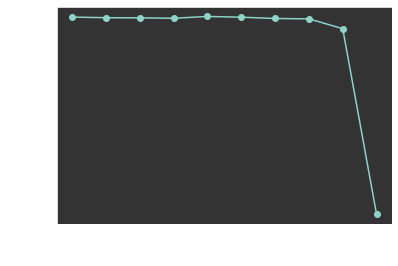

In [6]:
plt.plot(grid['param_ridge__alpha'], grid['mean_test_score'], marker = 'o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean test score')

#### SVR
There are two scenarios for the application of SVR. One is using PCA while the other one is using NMF as data representation. The script is grid_pilot_svr.py, which is submitted by submit_pilot.sh. The job log is slurm-43509.txt. The result is exported as pilot_grid_svr_20210318.csv. The best validation score is 0.905, which provided by the one using NMF.

### Short summary
It seems the ridge can provide reasonable prediction already. The combination of NMF and SVR produce the best prediction in cross-validation. The n_components is decided by the explaied variance of PCA. 

# Notes
Below are the actual-continued pilot workflow but not necessary fits to our paper's flow.

## TOC

In [149]:
y = merge_df.toc_percent.values

## GridsearchCV

In [134]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
params = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.02
The best parameter: {'ridge__alpha': 0.001}
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('ridge',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
CPU times: user 196 ms, sys: 67.6 ms, total: 263 ms
Wall time: 1.84 s


### Transform y by TransformedTargetRegressor

In [151]:
%%time
from sklearn.compose import TransformedTargetRegressor
transformer = StandardScaler()
regressor = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
regr = TransformedTargetRegressor(regressor=regressor,
                                 transformer=transformer)
params = {'regressor__ridge__alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(regr, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.02
The best parameter: {'regressor__ridge__alpha': 0.001}
TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('standardscaler',
                                                      StandardScaler(copy=True,
                                                                     with_mean=True,
                                                                     with_std=True)),
                                                     ('pca',
                                                      PCA(copy=True,
                                                          iterated_power='auto',
                                                          n_components=None,
                                                          random_state=None,
                                                          svd_solver='auto',
                    

In [152]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(StandardScaler(), PCA(n_components = 5, whiten = True), SVR())
regr = TransformedTargetRegressor(regressor = pipe,
                                 transformer = StandardScaler())
params = {
    'regressor__svr__C': np.logspace(-3, 3, 7),
    'regressor__svr__gamma': np.logspace(-3, 3, 7)
}

grid = GridSearchCV(regr, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.08
The best parameter: {'regressor__svr__C': 100.0, 'regressor__svr__gamma': 0.001}
TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('standardscaler',
                                                      StandardScaler(copy=True,
                                                                     with_mean=True,
                                                                     with_std=True)),
                                                     ('pca',
                                                      PCA(copy=True,
                                                          iterated_power='auto',
                                                          n_components=5,
                                                          random_state=None,
                                                          svd_solver='auto

In [155]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(NMF(n_components = 5, random_state = 24), SVR())
regr = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
params = {
    'regressor__svr__C': np.logspace(0, 7, 8),
    'regressor__svr__gamma': np.logspace(-8, 1, 10)
}
grid = GridSearchCV(regr, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.05
The best parameter: {'regressor__svr__C': 1000.0, 'regressor__svr__gamma': 1e-08}
TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('nmf',
                                                      NMF(alpha=0.0,
                                                          beta_loss='frobenius',
                                                          init=None,
                                                          l1_ratio=0.0,
                                                          max_iter=200,
                                                          n_components=5,
                                                          random_state=24,
                                                          shuffle=False,
                                                          solver='cd',
                                         

In [159]:
result_df = pd.DataFrame(grid.cv_results_)
result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

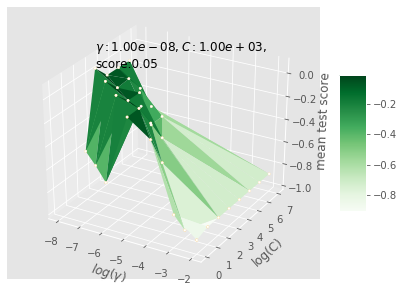

In [160]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = fig.gca(projection='3d')
xx = result_df.param_regressor__svr__gamma.astype(float)
yy = result_df.param_regressor__svr__C.astype(float)
zz = result_df.mean_test_score.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
# mark the best score
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
text = '$\gamma :{:.2e}, C:{:.2e}$,\nscore:{:.2f}'.format(xx[max_index], yy[max_index], zz[max_index])
ax.text(np.log10(xx[max_index]), np.log10(yy[max_index]), 
        zz[max_index],text,
        fontsize=12)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('toc_nmr+svr_toc_grid_scores_3D.png')

### Manualy transform y

In [164]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
scaler = StandardScaler()
y_train_s = scaler.fit_transform(y_train.reshape(-1,1))
y_test_s = scaler.transform(y_test.reshape(-1,1))
ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
ridge.fit(X_train, y_train_s)

print('Training set score: {:.2f}'.format(ridge.score(X_train, y_train_s)))
print('Test set score: {:.2f}'.format(ridge.score(X_test, y_test_s)))

Training set score: 1.00
Test set score: 0.37
CPU times: user 21.2 ms, sys: 3.84 ms, total: 25 ms
Wall time: 17.8 ms


## TC

In [125]:
y = merge_df.tc_percent.values

## GridsearchCV

In [23]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
params = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.87
The best parameter: {'ridge__alpha': 0.001}
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('ridge',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
CPU times: user 139 ms, sys: 15 ms, total: 154 ms
Wall time: 324 ms


In [24]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), PCA(n_components = 5, whiten = True), SVR())
params = {
    'svr__C': np.logspace(-3, 3, 7),
    'svr__gamma': np.logspace(-3, 3, 7)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.88
The best parameter: {'svr__C': 100.0, 'svr__gamma': 0.01}
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('svr',
                 SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma=0.01, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
CPU times: user 642 ms, sys: 44.9 ms, total: 687 ms
Wall time: 1.9 s


In [126]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(n_components = 5, random_state = 24), SVR())
params = {
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-8, 1, 10)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.91
The best parameter: {'svr__C': 10000.0, 'svr__gamma': 1e-06}
Pipeline(memory=None,
         steps=[('nmf',
                 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0,
                     max_iter=200, n_components=5, random_state=24,
                     shuffle=False, solver='cd', tol=0.0001, verbose=0)),
                ('svr',
                 SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=1e-06, kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)
CPU times: user 1.44 s, sys: 91.7 ms, total: 1.53 s
Wall time: 25.7 s


In [131]:
result_df = pd.DataFrame(grid.cv_results_)
result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

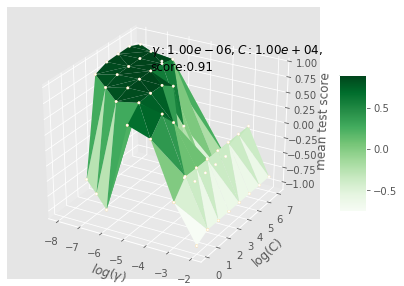

In [132]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = fig.gca(projection='3d')
xx = result_df.param_svr__gamma.astype(float)
yy = result_df.param_svr__C.astype(float)
zz = result_df.mean_test_score.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
# mark the best score
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
text = '$\gamma :{:.2e}, C:{:.2e}$,\nscore:{:.2f}'.format(xx[max_index], yy[max_index], zz[max_index])
ax.text(np.log10(xx[max_index]), np.log10(yy[max_index]), 
        zz[max_index],text,
        fontsize=12)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('tc_nmr+svr_toc_grid_scores_3D.png')

# Visualize the prediction accuracy
$CaCO_{3}$ and TC<br>
The best model of NMF+SVR.

In [3]:
y_ca = merge_df.caco3_percent.values
y_tc = merge_df.tc_percent.values
#y_toc = merge_df.toc_percent.values

In [5]:
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

ca_svr = make_pipeline(NMF(n_components = 5, random_state = 24), SVR(C = 1000000, gamma = 1e-07))
ca_svr.fit(X,y_ca)
tc_svr = make_pipeline(NMF(n_components = 5, random_state = 24), SVR(C = 10000, gamma = 1e-06))
tc_svr.fit(X,y_tc)

# The score of cross-validation is more robust than this score. 
# This one is just to see how the fitting goes.
print('The score of the CaCO3: {:.2f}'.format(ca_svr.score(X, y_ca)))
print('The score of the TC: {:.2f}'.format(tc_svr.score(X, y_tc)))

The score of the CaCO3: 0.95
The score of the TC: 0.96


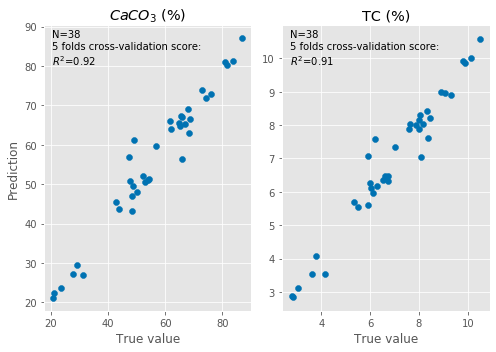

In [21]:
y_p = [ca_svr.predict(X), tc_svr.predict(X)]
scores = [0.92, 0.91] # this is from the cross-validation results above

fig, axes = plt.subplots(1, 2, figsize = (7, 5))

for ax, y, prediction, title, score in zip(axes, [y_ca, y_tc], y_p, [r'$CaCO_{3}$ (%)', 'TC (%)'], scores):
    ax.scatter(y, prediction)
    ax.set_xlabel('True value')
    ax.set_title(title)
    ax.text(0.04, 0.92, 'N=38\n5 folds cross-validation score:\n{}={}'.format(r'$R^{2}$', score), 
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
axes[0].set_ylabel('Prediction')
fig.tight_layout()
fig.savefig('truevalue_prediction.png')

# Summary
After larger scale of grid search on the CaCO3 data, the combination of NMF+SVR actually can provide better performance, 0.92. Therefore, I use the combination of NMF+SVR for gridsearch on TOC and TC. TC provide similarily good performance, 0.91, while TOC is so bad. I can produce the TC and CaCO3 profiles of these two cores in the resolution of XRF when JC wishs.

TOC-problem<br>
Even with the help of transforming y (TOC) by StandardScaler(), the performance is only improved from negative to 0.05. But, I'm not sure if the way of using TransformedTargetRegressor() is right. I'll mannualy do the grid search if JC is interested in that.

# Produce TC and $CaCO_{3}$ profiles

# Read and build spectral dataset of core SO264-14-1
For the core SO264-15-2, I just need to read the dataset I prepared already.

In [201]:
spe_dir = glob.glob('SO264-14-1/Run 1 at  10kV/*.spe')
spe_all = []
depth_all = []
cps_all = []
file_name = []

for spe in spe_dir:
    start_depth = int(spe.split()[3].split('_')[-1])
    file_name.append(spe.split('/')[-1])
    with open(spe, 'r') as f:
        content = []
        lines = f.readlines()
        for line in lines[49:]:
            content = np.hstack((content, line.split()))

        spe_all.append(content.astype(int))
        # the depth read from the xrf depth is in mm, but the composite depth is in cm
        # also I check the depth is always starts from 0.0 and in 10.0 mm resulotion
        # so I use this trick to make it to cm  e.g. '1000.0\n'
        depth_all.append(int(lines[13][:-4]) + start_depth)
        cps_all.append(int(lines[28]))

In [203]:
data_df = pd.DataFrame(spe_all)
data_df['composite_depth_cm'] = depth_all
data_df['cps'] = cps_all
data_df['file_name'] = file_name

In [204]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,composite_depth_cm,cps,file_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1708,218346,SO264-14-1_1641 670.0mm 10s 10kV 150uA No-F...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1703,213920,SO264-14-1_1641 620.0mm 10s 10kV 150uA No-F...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1072,161034,SO264-14-1_1041 310.0mm 10s 10kV 150uA No-F...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1075,196662,SO264-14-1_1041 340.0mm 10s 10kV 150uA No-F...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,792,172075,SO264-14-1_0741 510.0mm 10s 10kV 150uA No-F...


In [205]:
data_df.shape

(1828, 2051)

## Check duplicates

In [206]:
data_df.loc[data_df.composite_depth_cm.duplicated(keep = False), ['file_name', 'composite_depth_cm']]#.to_csv('duplicates.csv')

,file_name,composite_depth_cm
1051,SO264-14-1_0000 420.0mm 10s 10kV 150uA No-F...,42
1530,SO264-14-1_0041 10.0mm 10s 10kV 150uA No-F...,42


Only one pair of duplicate so I simply keep the first one.

In [207]:
clean_df = data_df[~data_df.composite_depth_cm.duplicated()]
clean_df.shape

(1827, 2051)

## Expot data

In [208]:
clean_df.to_csv('clean_spe_SO264-14-1.csv', index = False)

## Combile two cores' data

In [219]:
core_152_df = pd.read_csv('clean_spe_SO264-15-2.csv')
core_141_df = pd.read_csv('clean_spe_SO264-14-1.csv')
clean_df = pd.concat([core_152_df, core_141_df], axis = 0)
print(core_152_df.shape)
print(core_141_df.shape)
print(clean_df.shape)

(1340, 2051)
(1827, 2051)
(3167, 2051)


## Predict them!

In [220]:
mask_c = (clean_df.columns != 'file_name') & (clean_df.columns != 'composite_depth_cm')
X = clean_df.loc[:, mask_c].values

prediction_df = clean_df.loc[:, ~mask_c].copy()
prediction_df['caco3_percent'] = ca_svr.predict(X)
prediction_df['tc_percent'] = tc_svr.predict(X)

In [221]:
prediction_df.head()

,composite_depth_cm,file_name,caco3_percent,tc_percent
0,1082,SO264-15-2_1048 340.0mm 10s 10kV 150uA No-F...,73.851006,8.960110
1,1079,SO264-15-2_1048 310.0mm 10s 10kV 150uA No-F...,77.408529,9.328562
2,1404,SO264-15-2_1348 560.0mm 10s 10kV 150uA No-F...,46.358370,5.824017
3,350,SO264-15-2_0348 20.0mm 10s 10kV 150uA No-F...,53.129747,6.639450
4,41,SO264-15-2_0000 410.0mm 10s 10kV 150uA No-F...,46.268140,5.822396


### Export prediction

In [224]:
prediction_df.to_csv('prediction_tc+ca.csv', index = False)